In [4]:
import os
import nltk
import math
import pandas as pd
import pickle
import spacy
import numpy as np
import keras as K
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from keras.models import Sequential
from keras.layers import Dense, Activation
from nltk.corpus import stopwords

stopwords = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_lg')

Using TensorFlow backend.


# Tokenize + Stopwords + Lemmatize

In [26]:
# only adj and adv, no lemmatize on words like 'better' and 'best'
def clean_text_adjv_only(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', text, re.I | re.A).lower().replace('\n', '').strip()
    text = re.sub(' +', ' ', text)
    text = nlp(text)
    lemmatized = list()
    for token in text:
        lemma = token.lemma_
        if token.pos_ == 'ADJ' or token.pos_=='ADV':
            if token.tag_ == 'JJR' or token.tag_=='JJS':
                lemmatized.append(''.join(str(token)))
            else:
                if lemma not in stopwords:
                    lemmatized.append(''.join(lemma.split()))
    return " ".join(lemmatized)


# useful text only, no lemmatize on words like 'better' and 'best'
def clean_text_er_est(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', text, re.I | re.A).lower().replace('\n', '').strip()
    text = re.sub(' +', ' ', text)
    text = nlp(text)
    lemmatized = list()
    for token in text:
        lemma = token.lemma_
        if token.tag_ == 'JJR' or token.tag_=='JJS':
            lemmatized.append(''.join(str(token)))
        else:
            if not lemma=='-PRON-' and lemma not in stopwords and not lemma.isnumeric():
                lemmatized.append(''.join(lemma.split()))
    return " ".join(lemmatized)

# useful text only, no punctuation, no number, no pron
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', text, re.I | re.A).lower().replace('\n', '').strip()
    text = re.sub(' +', ' ', text)
    text = nlp(text)
    lemmatized = list()
    for token in text:
        lemma = token.lemma_
        if not lemma=='-PRON-' and lemma not in stopwords and not lemma.isnumeric():
            lemmatized.append(''.join(lemma.split()))
    return " ".join(lemmatized)  
    
# text with punctuation, no number
def clean_text_with_pun(text):
    text = text.lower().replace('\n', '').strip()
    text = re.sub(' +', ' ', text)
    text = nlp(text)
    lemmatized = list()   
    for token in text:
        lemma = token.lemma_
        if not lemma=='-PRON-' and lemma not in stopwords and not lemma.isnumeric():
            lemmatized.append(' '.join(lemma.split()))
    return " ".join(lemmatized)

# text with both number and punctuation
def clean_text_with_pun_num(text):
    text = text.lower().replace('\n', '').strip()
    text = re.sub(' +', ' ', text)
    text = nlp(text)
    lemmatized = list()
    for token in text:
        lemma = token.lemma_
        if not lemma=='-PRON-' and lemma not in stopwords:
            lemmatized.append(' '.join(lemma.split()))
    return " ".join(lemmatized)

# Try differences between functions
text ='The 3 best ways to process documents are so varied and application- and language-dependent that I decided to not constrain them by any interface. Instead, a document is represented by the features extracted from it, not by its "surface" string form: how you get to the features is up to you. Below I describe one common, general-purpose approach (called bag-of-words), but keep in mind that different application domains call for different features, and, as always, it’s garbage in, garbage out...'
print(text)
print()
text = clean_text_er_est(text)
print(text)

The 3 best ways to process documents are so varied and application- and language-dependent that I decided to not constrain them by any interface. Instead, a document is represented by the features extracted from it, not by its "surface" string form: how you get to the features is up to you. Below I describe one common, general-purpose approach (called bag-of-words), but keep in mind that different application domains call for different features, and, as always, it’s garbage in, garbage out...

best way process document varied application language dependent decide constrain interface instead document represent feature extract surface string form get feature describe one common general purpose approach call bag word keep mind different application domain call different feature always garbage garbage


# Load Data

In [3]:
def load_all_data(file_name):
    dataset = pd.read_csv(file_name)
    return dataset['business_id'], dataset["cool"], dataset['date'], dataset['funny'], dataset['review_id'], dataset['stars'], dataset['text'], dataset['useful'], dataset['user_id']

def load_data(file_name):
    dataset = pd.read_csv(file_name)
    return dataset['review_id'], dataset['text'],  dataset['stars']

def load_lables(file_name):
    return pd.read_csv(file_name)["stars"]

def write_predictions(file_name, pred):
    df = pd.DataFrame(zip(range(len(pred)),pred))
    df.columns = ["review_id","stars"]
    df.to_csv(file_name, index=False)
    
train_file = "data/train.csv"
test_file = "data/test.csv"
valid_file = "data/valid.csv"

# load data
train_ids, train_texts, train_labels = load_data(train_file)
test_ids, test_texts, test_labels = load_data(valid_file)

#clean_text
for i in range(len(train_texts)):
    train_texts[i] = clean_text(train_texts[i])
for i in range(len(test_texts)):
    test_texts[i] = clean_text(test_texts[i])
print(train_texts[0])

NameError: name 'clean_text' is not defined

In [75]:
data = {'train_texts':train_texts,
        'test_texts':test_texts,
        'train_ids':train_ids,
        'test_ids':test_ids,
        'train_labels':train_labels,
        'test_labels':test_labels,
       }
f = open('pkl/clean_text.pkl','wb')
pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
f.close()

# Extract Features

In [4]:
data = pd.read_pickle("pkl/clean_text.pkl")
train_texts = data.get("train_texts")
test_texts = data.get("test_texts")
train_labels = data.get("train_labels")
test_labels = data.get("test_labels")
train_ids = data.get("train_ids")
test_ids = data.get("test_ids")

Text(0, 0.5, 'Cumulative Numbers')

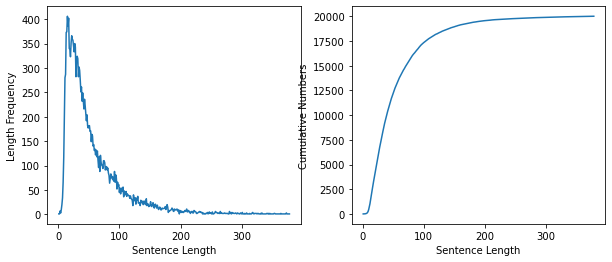

In [5]:
# See what features look like
# Help to set the min_freq, max_freq, max_len
train_feats = list()
for i in range(len(train_ids)):
    train_feats.append(nltk.word_tokenize(train_texts[i]))
test_feats = list()
for i in range(len(test_ids)):
    test_feats.append(nltk.word_tokenize(test_texts[i]))

plt.figure(figsize=(10,4))
len_cnt = Counter([len(feats) for feats in train_feats])
len_key = sorted(len_cnt)
plt.subplot(1,2,1)
plt.plot(range(1, len(len_key)+1),
         [len_cnt[l] for l in len_key])
plt.xlabel("Sentence Length")
plt.ylabel("Length Frequency")

plt.subplot(1,2,2)
plt.plot(range(1, len(len_key)+1),
         np.cumsum([len_cnt[l] for l in len_key]))
plt.xlabel("Sentence Length")
plt.ylabel("Cumulative Numbers")

# Word Embedding

In [6]:
def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = ["<pad>", "<unk>"] + [f for f, cnt in feat_cnt.most_common(max_size-2)]
    else:
        valid_feats = ["<pad>", "<unk>"]
        for f, cnt in feat_cnt.most_common():
            if ((min_freq == -1 or cnt >= min_freq) and (max_freq == -1 or cnt <= max_freq)):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]
    print("Size of features:", len(valid_feats))
    
    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    word_dict = dict(zip(range(len(valid_feats)),valid_feats,))
    return feats_dict,word_dict

In [10]:
print(feats_dict)

{'<pad>': 0, '<unk>': 1, 'good': 2, 'get': 3, 'go': 4, 'place': 5, 'food': 6, 'great': 7, 'time': 8, 'like': 9, 'come': 10, 'service': 11, 'order': 12, 'one': 13, 'make': 14, 'would': 15, 'back': 16, 'take': 17, 'well': 18, 'really': 19, 'try': 20, 'say': 21, 'also': 22, 'love': 23, 'look': 24, 'give': 25, 'nice': 26, 'even': 27, 'want': 28, 'restaurant': 29, 'price': 30, 'wait': 31, 'see': 32, 'know': 33, 'eat': 34, 'ask': 35, 'staff': 36, 'always': 37, 'think': 38, 'first': 39, 'day': 40, 'tell': 41, 'find': 42, 'work': 43, 'friendly': 44, 'experience': 45, 'never': 46, 'could': 47, 'people': 48, 'little': 49, 'need': 50, 'much': 51, 'definitely': 52, 'chicken': 53, 'recommend': 54, 'thing': 55, 'drink': 56, 'table': 57, 'call': 58, 'menu': 59, 'amazing': 60, 'feel': 61, 'delicious': 62, 'taste': 63, 'new': 64, 'bad': 65, 'customer': 66, 'way': 67, 'pretty': 68, 'minute': 69, 'two': 70, 'lot': 71, 'use': 72, 'hour': 73, 'room': 74, 'right': 75, 'friend': 76, 'night': 77, 'leave': 78,

In [8]:
vector_size = 300
min_freq = -1
max_freq = 18000 # 28000, 18000, 5000, 350
max_size = -1
max_len = 150

feats_dict,word_dict = get_feats_dict(chain.from_iterable(train_feats), min_freq, max_freq ,max_size)

def get_index_vector(feats, feats_dict, max_len):
    # initialize the vector as all zeros
    vector = np.zeros(max_len, dtype=np.int64)
    for i, f in enumerate(feats):
        if i == max_len:
            break
        # get the feature index, return 1 (<unk>) if the feature is not existed
        f_idx = feats_dict.get(f, 1)
        vector[i] = f_idx
    return vector

# Embedding(Using average spacy)
def get_spacy_vector(text):
    tokens = nlp(text)
    average = np.zeros(vector_size)
    count = 0
    for token in tokens:
        if feats_dict.get(token.text, -1) != -1:
            count += 1
            average += token.vector
    if count == 0:
        count = 1
    return average

# build the feats_matrix
# convert each example to a index vector, and then stack vectors as a matrix
# only store the words with proper frequency
train_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in train_texts])
test_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in test_texts])

# convert labels to label_matrix
num_classes = max(train_labels)
# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_label_matrix = K.utils.to_categorical(train_labels-1, num_classes=num_classes)
test_label_matrix = K.utils.to_categorical(test_labels-1, num_classes=num_classes)

# embedding matrix
l = min(len(feats_dict),max_freq)-max(0,min_freq)
embedding_matrix = np.zeros((l, vector_size), dtype=np.float32)
for i in range (max(0,min_freq),min(len(feats_dict),max_freq)):
    embedding_matrix[i-max(0,min_freq)] = nlp(word_dict.get(i)).vector

Size of features: 31424


In [9]:
data = {'train_feats':train_feats,
        'test_feats':test_feats,
        'feats_dict':feats_dict,
        'word_dict':word_dict,
        'min_freq':min_freq,
        'max_freq':max_freq,
        'max_len':max_len,
        'train_feats_matrix':train_feats_matrix,
        'test_feats_matrix':test_feats_matrix,
        'embedding_matrix':embedding_matrix
       }
f = open('pkl/feats.pkl','wb')
pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
f.close()